In [1]:
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_sample_interval, load, save

# Neural Data

## Load Data

In [21]:
%%time
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

CPU times: user 1min 20s, sys: 8 s, total: 1min 28s
Wall time: 2min 53s


# Load and Combine Results

In [62]:
%%time
data_dir = "../../__data__/slds/slds_big_run_full_brain_Oct-22-2021_1651"
run_params = load(os.path.join(data_dir, "run_params"))
results_files = [f for f in os.listdir(data_dir) if f.startswith('start_time')]
results = []
for file in results_files:
    results.append(load(os.path.join(data_dir, file)))
results = sorted(results, key=lambda d: d['start_time'])
results = pd.DataFrame(results)

CPU times: user 2.51 ms, sys: 5.85 s, total: 5.85 s
Wall time: 5.85 s


# Analyze

In [63]:
duration =  run_params['duration']
stride = duration
length =  run_params['length']
var_names =  run_params['var_names']
emissions_dim = run_params['emissions_dim']
n_disc_states = run_params['n_disc_states']
latent_dim = run_params['latent_dim']

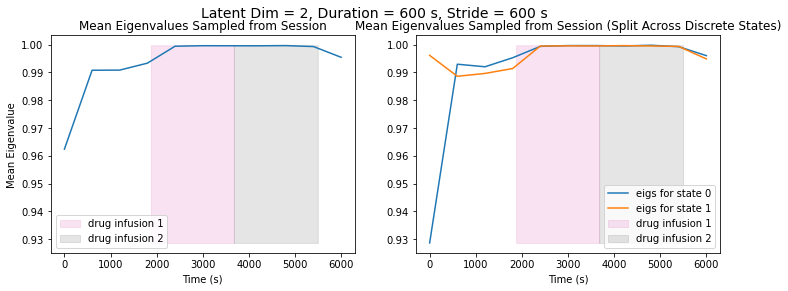

In [71]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

ax = axs[0]
start_times = results.start_time
mean_eigs = np.array([mat.mean() for mat in results.criticality_inds])
ax.plot(start_times, mean_eigs)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Eigenvalue')
ax.set_title("Mean Eigenvalues Sampled from Session")


ax = axs[1]
mean_eigs = np.array([mat.mean(axis=1) for mat in results.criticality_inds])
for i in range(n_disc_states):
    ax.plot(start_times, mean_eigs[:, i], label=f'eigs for state {i}')
ax.set_xlabel('Time (s)')
# ax.set_ylabel('Mean Eigenvalue')
ax.set_title("Mean Eigenvalues Sampled from Session (Split Across Discrete States)")
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
ax.legend()
ax.yaxis.set_tick_params(labelbottom=True)

# make coloured portions the same size
ax = axs[0]
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
ax.legend()

plt.suptitle(f"Latent Dim = {latent_dim}, Duration = {duration} s, Stride = {stride} s", fontsize=14)

plt.show()

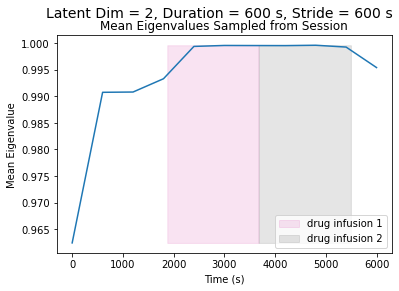

In [72]:
fig = plt.figure()
ax = plt.gca()
mean_eigs = np.array([mat.mean() for mat in results.criticality_inds])
ax.plot(start_times, mean_eigs)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Eigenvalue')
ax.set_title("Mean Eigenvalues Sampled from Session")
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C6', alpha=0.2, label='drug infusion 1')
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], dt), 
                            mean_eigs.min(), mean_eigs.max(), color='C7', alpha=0.2, label='drug infusion 2')
ax.legend()
plt.suptitle(f"Latent Dim = {latent_dim}, Duration = {duration} s, Stride = {stride} s", fontsize=14)
plt.show()

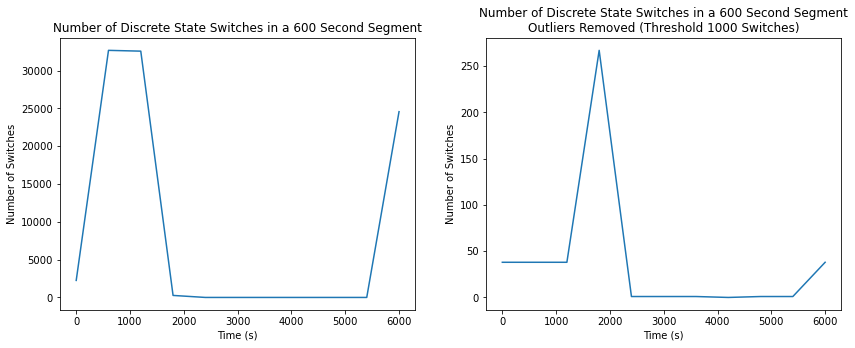

In [58]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
num_switches = np.array([np.sum(np.diff(arr != 0)) for arr in results.disc_states])
plt.plot(start_times, num_switches)
plt.title(f"Number of Discrete State Switches in a {duration} Second Segment")
plt.xlabel('Time (s)')
plt.ylabel('Number of Switches')

plt.subplot(1, 2, 2)
thresh = 1000
num_switches[num_switches > thresh] = num_switches[num_switches <= thresh].mean()
plt.plot(start_times, num_switches)
plt.title(f"Number of Discrete State Switches in a {duration} Second Segment\nOutliers Removed (Threshold {thresh} Switches)")
plt.xlabel('Time (s)')
plt.ylabel('Number of Switches')

plt.show()

In [151]:
row = results.iloc[0]

In [152]:
row

start_time                                                          0
start_step                                                          0
slds                          <ssm.lds.SLDS object at 0x7fa23de71640>
q_lem_elbos         [299889874.4671595, 322076762.6082287, 3227975...
q_lem               <ssm.variational.SLDSStructuredMeanFieldVariat...
eigs                [[(0.9234286147283733+0j), (0.9339538666249325...
criticality_inds    [[0.9339538666249325, 0.9234286147283733], [0....
mse                                                           0.00096
disc_states         [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 0, dtype: object